In [1]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('wildfire_preprocessed_V1.csv')

In [2]:
df.head()

,DSPT_REQ_HR,FIRE_SUPESN_HR,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_unknown,CMBS_EXPOBJ_LCLSF_NM_GAS,...,WNDRCT_BRNG_west,WNDRCT_BRNG_SE,WNDRCT_BRNG_SW,WNDRCT_BRNG_NE,WNDRCT_BRNG_NW,dispatch_time_diff,arrival_time_diff,golden_time_under_50min,is_night,month_rcpt
0,5.509388,7.090910,2.484907,1.609438,-1.0,39.0,1,1,0,0,...,0,0,0,0,1,4.521789,5.823046,1,1,1
1,5.537334,6.398595,1.609438,1.098612,5.0,60.0,1,3,0,0,...,0,0,1,0,0,3.663562,5.676754,1,1,3
2,6.467699,7.284821,2.302585,1.791759,7.0,49.0,1,3,0,0,...,0,0,1,0,0,3.526361,6.517671,1,1,3
3,6.361302,7.333023,1.791759,1.098612,0.3,48.0,3,3,0,0,...,0,0,0,0,1,4.077537,6.456770,1,0,3
4,6.774224,9.579487,3.295837,2.397895,-8.7,36.0,5,12,0,0,...,1,0,0,0,0,3.496508,6.810142,1,1,12


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping  # (옵션) log_evaluation도 필요시 추가

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# 파일 경로
CSV_PATH = "wildfire_preprocessed_V1.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "FIRE_SUPESN_HR"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 모델에서 제외할 컬럼(있으면 제거)
EXCLUDE_COLS = {
    "total_time", "fire_supesn_hr", "relax_diff", "wind_speed_mean",
    TARGET  # 타깃은 당연히 피처에서 제외
}

# 숫자형 컬럼만 사용(원-핫 완료 가정) + 제외 컬럼 제거
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in EXCLUDE_COLS]

# 필요 시 누수 변수 제거 (새 데이터에 없으면 자동 무시)
LEAKY_COL = "ARRIVAL_DELAY_MIN_LOG"
if not INCLUDE_LEAKY and LEAKY_COL in feature_cols:
    feature_cols.remove(LEAKY_COL)

# 안전장치: 피처가 하나도 없으면 에러
if len(feature_cols) == 0:
    raise ValueError("선택된 피처가 없습니다. EXCLUDE_COLS 또는 전처리를 확인하세요.")

print(f"선택된 피처 수: {len(feature_cols)}")
print("제외된 컬럼(데이터에 존재했던 항목만):",
      sorted([c for c in EXCLUDE_COLS if c in df.columns]))

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")

행: 3,359, 열: 66

컬럼명:
 ['DSPT_REQ_HR', 'FIRE_SUPESN_HR', 'FRSTN_GRNDS_DSTNC', 'CNTR_GRNDS_DSTNC', 'HR_UNIT_ARTMP', 'HR_UNIT_HUM', 'WSPD_BIN', 'MONTH', 'CMBS_EXPOBJ_LCLSF_NM_unknown', 'CMBS_EXPOBJ_LCLSF_NM_GAS', 'CMBS_EXPOBJ_LCLSF_NM_ETC', 'CMBS_EXPOBJ_LCLSF_NM_GARBAGE', 'CMBS_EXPOBJ_LCLSF_NM_DANGER', 'CMBS_EXPOBJ_LCLSF_NM_VEHICLE_TRAIN_SHIP_AIRCRAFT', 'CMBS_EXPOBJ_LCLSF_NM_ELEC', 'CMBS_EXPOBJ_LCLSF_NM_PAPER_WOOD', 'CMBS_EXPOBJ_LCLSF_NM_BED_WOOL', 'CMBS_EXPOBJ_LCLSF_NM_PLASTIC', 'CMBS_EXPOBJ_LCLSF_NM_nan', 'IGTN_HTSRC_NM_ETC', 'IGTN_HTSRC_NM_SMOKE', 'IGTN_HTSRC_NM_FRICTION', 'IGTN_HTSRC_NM_unknown', 'IGTN_HTSRC_NM_SPARK', 'IGTN_HTSRC_NM_NATURAL', 'IGTN_HTSRC_NM_MACHINE', 'IGTN_HTSRC_NM_EXPLOSIVE', 'IGTN_HTSRC_NM_CHEMICAL', 'CTPV_NM_busan', 'CTPV_NM_chungbuk', 'CTPV_NM_chungnam', 'CTPV_NM_daegu', 'CTPV_NM_daejeon', 'CTPV_NM_gangwon', 'CTPV_NM_gwangju', 'CTPV_NM_gyeongbuk', 'CTPV_NM_gyeonggi', 'CTPV_NM_gyeongnam', 'CTPV_NM_incheon', 'CTPV_NM_jeju', 'CTPV_NM_jeonbuk', 'CTPV_NM_jeonnam', 'C

,DSPT_REQ_HR,FIRE_SUPESN_HR,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_unknown,CMBS_EXPOBJ_LCLSF_NM_GAS,...,WNDRCT_BRNG_west,WNDRCT_BRNG_SE,WNDRCT_BRNG_SW,WNDRCT_BRNG_NE,WNDRCT_BRNG_NW,dispatch_time_diff,arrival_time_diff,golden_time_under_50min,is_night,month_rcpt
0,5.509388,7.090910,2.484907,1.609438,-1.0,39.0,1,1,0,0,...,0,0,0,0,1,4.521789,5.823046,1,1,1
1,5.537334,6.398595,1.609438,1.098612,5.0,60.0,1,3,0,0,...,0,0,1,0,0,3.663562,5.676754,1,1,3
2,6.467699,7.284821,2.302585,1.791759,7.0,49.0,1,3,0,0,...,0,0,1,0,0,3.526361,6.517671,1,1,3
3,6.361302,7.333023,1.791759,1.098612,0.3,48.0,3,3,0,0,...,0,0,0,0,1,4.077537,6.456770,1,0,3
4,6.774224,9.579487,3.295837,2.397895,-8.7,36.0,5,12,0,0,...,1,0,0,0,0,3.496508,6.810142,1,1,12


선택된 피처 수: 65
제외된 컬럼(데이터에 존재했던 항목만): ['FIRE_SUPESN_HR']

최종 데이터 크기: X=(3359, 65), y=(3359,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [5]:
# === 0) 기본 설정 & Train/Test 분리 ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 전제: X, y 가 이미 준비되어 있음 (pandas DataFrame / Series 권장)
assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."

RANDOM_STATE = 42
TEST_SIZE    = 0.2      # 80/20 분리
TARGET_IS_LOG = True    # y가 log1p 스케일이면 True (expm1로 복원용)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}  Test: {X_test.shape}")


Train: (2687, 65)  Test: (672, 65)


In [8]:
# === 1) 하이퍼파라미터 최적화 (Train 전용, 5-fold CV, LightGBM) ===
import numpy as np
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

def optimize_hyperparameters_lgbm(X_tr, y_tr, random_state=42):
    """
    LightGBM 하이퍼파라미터 그리드 탐색 (5-fold, MSE 기준)
    """
    print("=== [Step 1] 하이퍼파라미터 최적화 (Train 전용, LightGBM) ===")
    lgbm = LGBMRegressor(random_state=random_state, n_jobs=-1)

    param_grid = {
        "n_estimators": [300, 600],     # 부스팅 라운드 수
        "learning_rate": [0.05, 0.1],   # 학습률
        "num_leaves": [31, 63],         # 리프 수
        "min_child_samples": [20, 40]   # 리프 최소 데이터 수
    }

    gscv = GridSearchCV(
        estimator=lgbm,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',   # RMSE 원하면 'neg_root_mean_squared_error'
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X_tr, y_tr)

    best_params = gscv.best_params_
    best_mse = -gscv.best_score_

    print(f"\n최적 하이퍼파라미터: {best_params}")
    print(f"최적 CV MSE: {best_mse:,.6f} (RMSE={np.sqrt(best_mse):,.6f})")

    return best_params

# 실행
best_params = optimize_hyperparameters_lgbm(X_train, y_train, random_state=RANDOM_STATE)
print("\n[Step 1 결과] best_params =", best_params)


=== [Step 1] 하이퍼파라미터 최적화 (Train 전용, LightGBM) ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 2150, number of used features: 50
[LightGBM] [Info] Start training from score 8.062232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 2150, number of used features: 51
[LightGBM] [Info] Start training from score 8.087087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testi

In [10]:
# === 2) 고정 하이퍼파라미터로 10번 반복(CV=5) → 베스트 run 선택 (LightGBM) ===
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

def model_factory_lgbm(best_params, seed, n_jobs=-1):
    """seed만 바꿔 동일 하이퍼파라미터의 LGBM 생성"""
    # best_params에 있는 값 그대로 넘기되, random_state/n_jobs만 보장
    return LGBMRegressor(
        random_state=seed,
        n_jobs=n_jobs,
        **best_params
    )

def pick_best_model_over_runs_lgbm(X_tr, y_tr, best_params, n_runs=10, n_splits=5, base_seed=1000):
    """
    고정된 하이퍼파라미터로 서로 다른 seed로 10번 반복.
    각 run마다 5-fold CV를 돌려 '평균 MSE'가 가장 낮은 run을 베스트로 선정.
    선정된 run의 seed로 Train 전체 재학습한 모델 반환.
    """
    print("\n=== [Step 2] 10번 반복 CV → 베스트 run 선택 (LightGBM) ===")
    run_summaries = []
    best_run_idx = None
    best_cv_mse = np.inf
    seeds = [base_seed + i for i in range(n_runs)]

    for i, seed in enumerate(seeds, start=1):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        fold_mse = []

        for tr_idx, va_idx in kf.split(X_tr):
            X_tr_fold, X_va_fold = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
            y_tr_fold, y_va_fold = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]

            model = model_factory_lgbm(best_params, seed=seed)
            model.fit(X_tr_fold, y_tr_fold)
            y_va_pred = model.predict(X_va_fold)
            mse = mean_squared_error(y_va_fold, y_va_pred)
            fold_mse.append(mse)

        cv_mse = float(np.mean(fold_mse))
        cv_rmse = float(np.sqrt(cv_mse))
        run_summaries.append((seed, cv_mse, cv_rmse))
        print(f"[Run {i:02d} | seed={seed}] CV MSE={cv_mse:.6f} (RMSE={cv_rmse:.6f})")

        if cv_mse < best_cv_mse:
            best_cv_mse = cv_mse
            best_run_idx = i - 1  # 0-based

    best_seed, best_mse, best_rmse = run_summaries[best_run_idx]
    print(f"\n>>> 베스트 run: #{best_run_idx+1} (seed={best_seed})  "
          f"CV MSE={best_mse:.6f} (RMSE={best_rmse:.6f})")

    # 베스트 run의 seed로 Train 전체 재학습
    best_model = model_factory_lgbm(best_params, seed=best_seed)
    best_model.fit(X_tr, y_tr)

    return best_model, run_summaries

# 실행
best_model, run_summaries = pick_best_model_over_runs_lgbm(
    X_train, y_train, best_params, n_runs=10, n_splits=5, base_seed=1000
)
print(best_model)

print("\n[Step 2 결과] run 요약 (seed, CV MSE, CV RMSE):")
for seed, mse, rmse in run_summaries:
    print(f"  seed={seed} | MSE={mse:.6f} | RMSE={rmse:.6f}")



=== [Step 2] 10번 반복 CV → 베스트 run 선택 (LightGBM) ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1251
[LightGBM] [Info] Number of data points in the train set: 2149, number of used features: 46
[LightGBM] [Info] Start training from score 8.076661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [12]:
# === 3) 베스트 모델로 Test 평가 (로그/원 단위) ===
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_on_test(best_model, X_te, y_te, target_is_log=True, time_unit="min", show_both=True):
    """로그 스케일/원 단위 지표 동시 출력"""
    def to_unit(v_sec, unit="sec"):
        if unit == "min":  return v_sec / 60.0
        if unit == "hour": return v_sec / 3600.0
        return v_sec
    def unit_label(unit):
        return {"sec":"초", "min":"분", "hour":"시간"}[unit]
    def hhmm(v_sec):
        v_sec = float(v_sec); h = int(v_sec // 3600); m = int((v_sec % 3600) // 60)
        return f"{h}h {m}m"
    def show(name, v_sec):
        main = to_unit(v_sec, time_unit)
        s = f"{name}: {main:,.2f} {unit_label(time_unit)}"
        if show_both:
            other = {"sec":"min", "min":"hour", "hour":"min"}[time_unit]
            s += f"  |  ({to_unit(v_sec, other):,.2f} {unit_label(other)}, ~{hhmm(v_sec)})"
        return s

    # 로그 스케일 지표
    y_pred_log = best_model.predict(X_te)
    rmse_log = float(np.sqrt(mean_squared_error(y_te, y_pred_log)))
    mae_log  = float(mean_absolute_error(y_te, y_pred_log))
    r2_log   = float(r2_score(y_te, y_pred_log))
    print("\n=== [Step 3] Test 성능 — 로그 스케일 ===")
    print(f"RMSE={rmse_log:.4f}  MAE={mae_log:.4f}  R²={r2_log:.4f}")

    # 원 단위 지표
    if target_is_log:
        y_true_o = np.expm1(y_te)
        y_pred_o = np.expm1(y_pred_log)
    else:
        y_true_o = y_te
        y_pred_o = y_pred_log

    rmse_o = float(np.sqrt(mean_squared_error(y_true_o, y_pred_o)))
    mae_o  = float(mean_absolute_error(y_true_o, y_pred_o))
    r2_o   = float(r2_score(y_true_o, y_pred_o))

    print("\n=== Test 성능 — 원 단위 ===")
    print(show("RMSE", rmse_o))
    print(show("MAE",  mae_o))
    print(f"R²  : {r2_o:.4f}  (역변환 후 R²는 참고용)")

# 실행
evaluate_on_test(best_model, X_test, y_test, target_is_log=TARGET_IS_LOG, time_unit="min")



=== [Step 3] Test 성능 — 로그 스케일 ===
RMSE=1.3455  MAE=0.9476  R²=0.1096

=== Test 성능 — 원 단위 ===
RMSE: 154.37 분  |  (2.57 시간, ~2h 34m)
MAE: 73.39 분  |  (1.22 시간, ~1h 13m)
R²  : 0.0113  (역변환 후 R²는 참고용)



Top-10 Feature Importances:


,feature,importance
3,HR_UNIT_ARTMP,2262
60,dispatch_time_diff,1943
4,HR_UNIT_HUM,1857
0,DSPT_REQ_HR,1547
61,arrival_time_diff,1484
1,FRSTN_GRNDS_DSTNC,1305
2,CNTR_GRNDS_DSTNC,1251
6,MONTH,725
47,FND_IGTN_PSTN_NM_under,236
17,CMBS_EXPOBJ_LCLSF_NM_nan,211


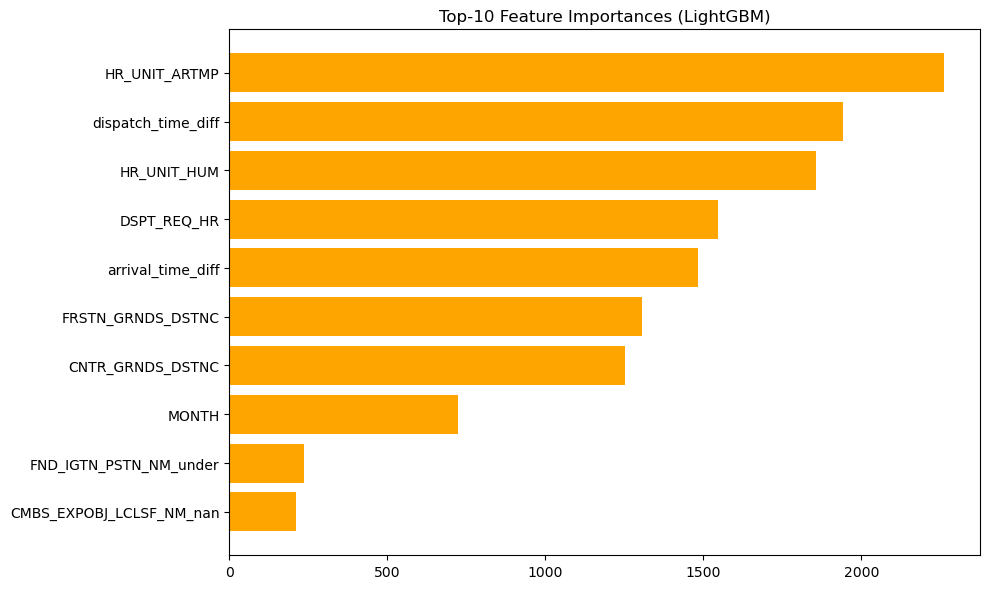

In [13]:
# === 4) LightGBM 특성 중요도 Top-10 ===
import matplotlib.pyplot as plt

fi = pd.DataFrame({
    "feature": list(X_train.columns),
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop-10 Feature Importances:")
display(fi.head(10))

plt.figure(figsize=(10,6))
top = fi.head(10).iloc[::-1]
plt.barh(range(len(top)), top["importance"], color="Orange")
plt.yticks(range(len(top)), top["feature"])
plt.title("Top-10 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()
